In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import time
from sklearn.pipeline import Pipeline

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

In [4]:
# Load a classification dataset
cancer = load_breast_cancer()
X_class = cancer.data
y_class = cancer.target

In [5]:
# Load a regression dataset
diabetes = load_diabetes()
X_reg = diabetes.data
y_reg = diabetes.target

In [6]:
# Split data into training and testing sets
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

In [7]:
# Standardize features
scaler = StandardScaler()
X_class_train_scaled = scaler.fit_transform(X_class_train)
X_class_test_scaled = scaler.transform(X_class_test)

In [8]:
X_reg_train_scaled = scaler.fit_transform(X_reg_train)
X_reg_test_scaled = scaler.transform(X_reg_test)

# Part 1: Grid Search for SVM Classifier

In [9]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly']
}

In [10]:
# Create SVM classifier
svm = SVC(random_state=42)

In [11]:
# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring='accuracy',
    return_train_score=True
)

In [12]:
# Start timing
start_time = time.time()


In [13]:
# Fit GridSearchCV
grid_search.fit(X_class_train_scaled, y_class_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf', 'poly']},
             return_train_score=True, scoring='accuracy')

In [14]:
# End timing
grid_time = time.time() - start_time

In [15]:
# Print results
print(f"Grid Search completed in {grid_time:.2f} seconds")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Grid Search completed in 71.38 seconds
Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.9736


In [16]:
# Evaluate on test set
y_pred = grid_search.predict(X_class_test_scaled)
grid_accuracy = accuracy_score(y_class_test, y_pred)
print(f"Test accuracy with optimal parameters: {grid_accuracy:.4f}")

Test accuracy with optimal parameters: 0.9825


In [17]:
# Visualization of Grid Search results
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_pivot = grid_results.pivot_table(
    values='mean_test_score',
    index='param_C',
    columns='param_gamma'
)

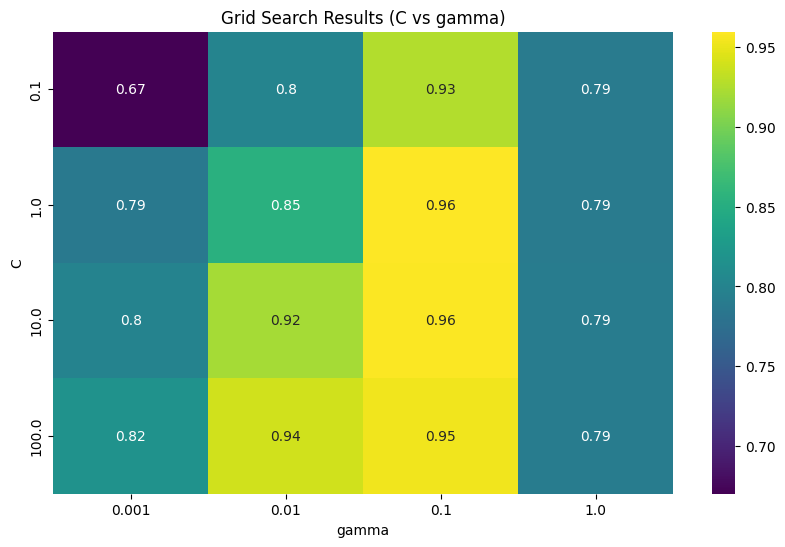

In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(grid_pivot, annot=True, cmap='viridis')
plt.title('Grid Search Results (C vs gamma)')
plt.ylabel('C')
plt.xlabel('gamma')
plt.show()


# Part 2: Random Search for SVM Classifier

In [19]:
# Define the parameter distributions
param_dist = {
    'C': uniform(0.1, 100),
    'gamma': uniform(0.001, 1),
    'kernel': ['rbf', 'poly']
}


In [20]:
# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,
    n_jobs=-1,
    verbose=0,
    random_state=42,
    scoring='accuracy',
    return_train_score=True
)

In [21]:
# Start timing
start_time = time.time()

In [22]:
# Fit RandomizedSearchCV
random_search.fit(X_class_train_scaled, y_class_train)

RandomizedSearchCV(cv=5, estimator=SVC(random_state=42), n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000021793214EF0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000217B6DD9220>,
                                        'kernel': ['rbf', 'poly']},
                   random_state=42, return_train_score=True,
                   scoring='accuracy')

In [23]:
# End timing
random_time = time.time() - start_time

In [24]:
# Print results
print(f"Random Search completed in {random_time:.2f} seconds")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

Random Search completed in 18.60 seconds
Best parameters: {'C': np.float64(0.8066305219717406), 'gamma': np.float64(0.024062425041415758), 'kernel': 'rbf'}
Best cross-validation score: 0.9714


In [25]:
# Evaluate on test set
y_pred = random_search.predict(X_class_test_scaled)
random_accuracy = accuracy_score(y_class_test, y_pred)
print(f"Test accuracy with optimal parameters: {random_accuracy:.4f}")

Test accuracy with optimal parameters: 0.9649


In [27]:
# Compare Grid Search and Random Search
results_comparison = pd.DataFrame({
    'Method': ['Grid Search', 'Random Search'],
    'Best CV Score': [grid_search.best_score_, random_search.best_score_],
    'Test Accuracy': [grid_accuracy, random_accuracy],
    'Execution Time (s)': [grid_time, random_time]
})

print("\nComparison of Grid Search and Random Search:")
print(results_comparison)


Comparison of Grid Search and Random Search:
          Method  Best CV Score  Test Accuracy  Execution Time (s)
0    Grid Search       0.973626       0.982456           71.383764
1  Random Search       0.971429       0.964912           18.599779


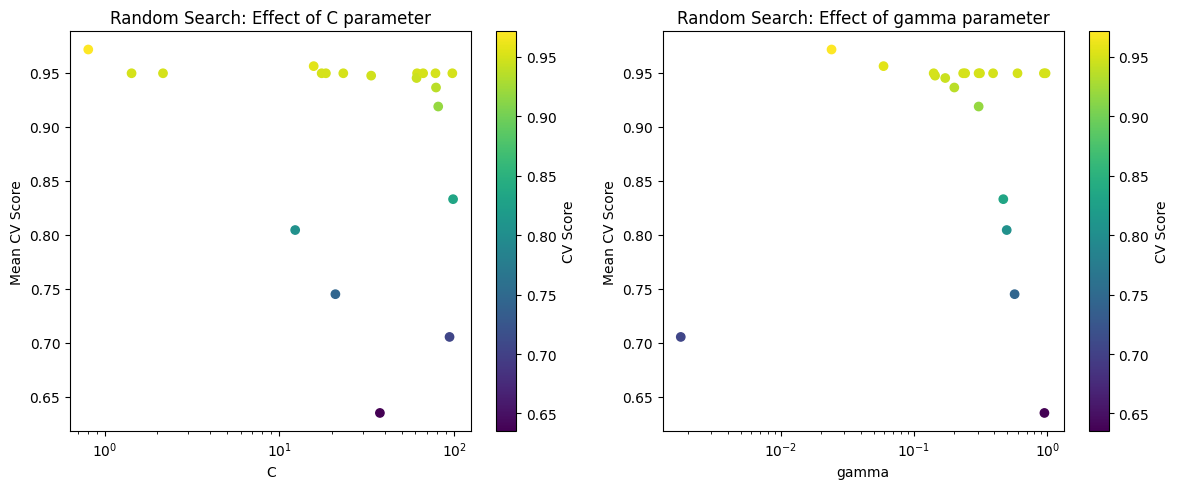

In [28]:
# Visualize random search results - plot parameter samples and their scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(random_search.cv_results_['param_C'],
            random_search.cv_results_['mean_test_score'],
            c=random_search.cv_results_['mean_test_score'],
            cmap='viridis')
plt.colorbar(label='CV Score')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Mean CV Score')
plt.title('Random Search: Effect of C parameter')

plt.subplot(1, 2, 2)
plt.scatter(random_search.cv_results_['param_gamma'],
            random_search.cv_results_['mean_test_score'],
            c=random_search.cv_results_['mean_test_score'],
            cmap='viridis')
plt.colorbar(label='CV Score')
plt.xscale('log')
plt.xlabel('gamma')
plt.ylabel('Mean CV Score')
plt.title('Random Search: Effect of gamma parameter')
plt.tight_layout()
plt.show()

# Part 3: Bayesian Optimization using scikit-optimize (skopt)

In [29]:
# Install scikit-optimize if not already installed
!pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [31]:
# Define the search space
search_spaces = {
    'C': Real(0.1, 100, prior='log-uniform'),
    'gamma': Real(0.001, 1.0, prior='log-uniform'),
    'kernel': Categorical(['rbf', 'poly'])
}

In [32]:
# Create BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=svm,
    search_spaces=search_spaces,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,
    n_jobs=-1,
    verbose=0,
    random_state=42,
    scoring='accuracy',
    return_train_score=True
)

In [33]:
# Start timing
start_time = time.time()

In [34]:
# Fit BayesSearchCV
bayes_search.fit(X_class_train_scaled, y_class_train)

BayesSearchCV(cv=5, estimator=SVC(random_state=42), n_iter=20, n_jobs=-1,
              random_state=42, return_train_score=True, scoring='accuracy',
              search_spaces={'C': Real(low=0.1, high=100, prior='log-uniform', transform='normalize'),
                             'gamma': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'kernel': Categorical(categories=('rbf', 'poly'), prior=None)})

In [35]:
# End timing
bayes_time = time.time() - start_time

In [36]:
# Print results
print(f"Bayesian Optimization completed in {bayes_time:.2f} seconds")
print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best cross-validation score: {bayes_search.best_score_:.4f}")

Bayesian Optimization completed in 32.16 seconds
Best parameters: OrderedDict({'C': 47.479208101335, 'gamma': 0.015041969444179404, 'kernel': 'rbf'})
Best cross-validation score: 0.9626


In [37]:
# Evaluate on test set
y_pred = bayes_search.predict(X_class_test_scaled)
bayes_accuracy = accuracy_score(y_class_test, y_pred)
print(f"Test accuracy with optimal parameters: {bayes_accuracy:.4f}")

Test accuracy with optimal parameters: 0.9561


In [38]:
# Update comparison table
results_comparison = pd.DataFrame({
    'Method': ['Grid Search', 'Random Search', 'Bayesian Optimization'],
    'Best CV Score': [grid_search.best_score_, random_search.best_score_, bayes_search.best_score_],
    'Test Accuracy': [grid_accuracy, random_accuracy, bayes_accuracy],
    'Execution Time (s)': [grid_time, random_time, bayes_time]
})

print("\nComparison of all methods:")
print(results_comparison)


Comparison of all methods:
                  Method  Best CV Score  Test Accuracy  Execution Time (s)
0            Grid Search       0.973626       0.982456           71.383764
1          Random Search       0.971429       0.964912           18.599779
2  Bayesian Optimization       0.962637       0.956140           32.158671


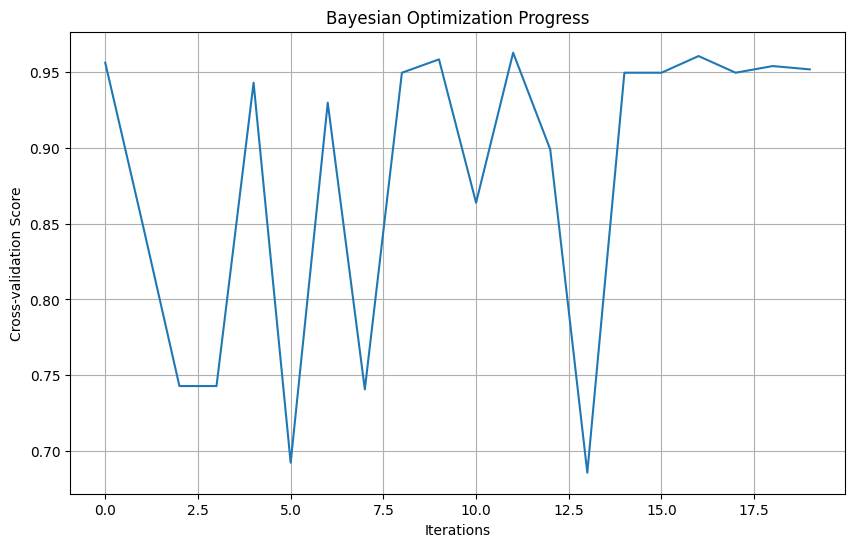

In [39]:
# Visualize Bayesian Optimization progress
plt.figure(figsize=(10, 6))
plt.plot(bayes_search.cv_results_['mean_test_score'])
plt.xlabel('Iterations')
plt.ylabel('Cross-validation Score')
plt.title('Bayesian Optimization Progress')
plt.grid(True)
plt.show()

# Part 4: Random Forest Regression with hyperparameter tuning

In [40]:
# Create a pipeline for regression
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [41]:
# Define parameter distributions for random search
rf_param_dist = {
    'regressor__n_estimators': randint(10, 200),
    'regressor__max_depth': randint(3, 20),
    'regressor__min_samples_split': randint(2, 20),
    'regressor__min_samples_leaf': randint(1, 10),
    'regressor__max_features': ['auto', 'sqrt', 'log2', None]
}

In [42]:
# Create RandomizedSearchCV for regression
rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=0,
    random_state=42,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

In [43]:
# Start timing
start_time = time.time()

In [44]:
# Fit RandomizedSearchCV
rf_random_search.fit(X_reg_train, y_reg_train)

C:\Users\Ali Computers\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\Ali Computers\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Ali Computers\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('regressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'regressor__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000217BA4DF980>,
                                        'regressor__max_features': ['auto',
                                                                    'sqrt',
                                                                    'log2',
                                                                    None],
                                        'regressor__min_sa...astructure.rv_discrete_frozen object at 0x00000217BA5650A0>,
                                        'regressor__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000217BA486120>,
                                        'regressor__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000217BA419790>},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [45]:
# End timing
rf_random_time = time.time() - start_time

In [46]:
# Print results
print("\nRandom Forest Regression Hyperparameter Tuning Results:")
print(f"Random Search completed in {rf_random_time:.2f} seconds")
print(f"Best parameters: {rf_random_search.best_params_}")
print(f"Best cross-validation score (neg_mean_squared_error): {rf_random_search.best_score_:.4f}")


Random Forest Regression Hyperparameter Tuning Results:
Random Search completed in 17.15 seconds
Best parameters: {'regressor__max_depth': 18, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 8, 'regressor__min_samples_split': 15, 'regressor__n_estimators': 199}
Best cross-validation score (neg_mean_squared_error): -3316.3419


In [47]:
# Evaluate on test set
y_pred = rf_random_search.predict(X_reg_test)
mse = mean_squared_error(y_reg_test, y_pred)
r2 = r2_score(y_reg_test, y_pred)
print(f"Test MSE with optimal parameters: {mse:.4f}")
print(f"Test R² with optimal parameters: {r2:.4f}")

Test MSE with optimal parameters: 2808.9704
Test R² with optimal parameters: 0.4698


In [48]:
# Visualize feature importance from the best model
best_rf = rf_random_search.best_estimator_.named_steps['regressor']
feature_importance = best_rf.feature_importances_
feature_names = diabetes.feature_names

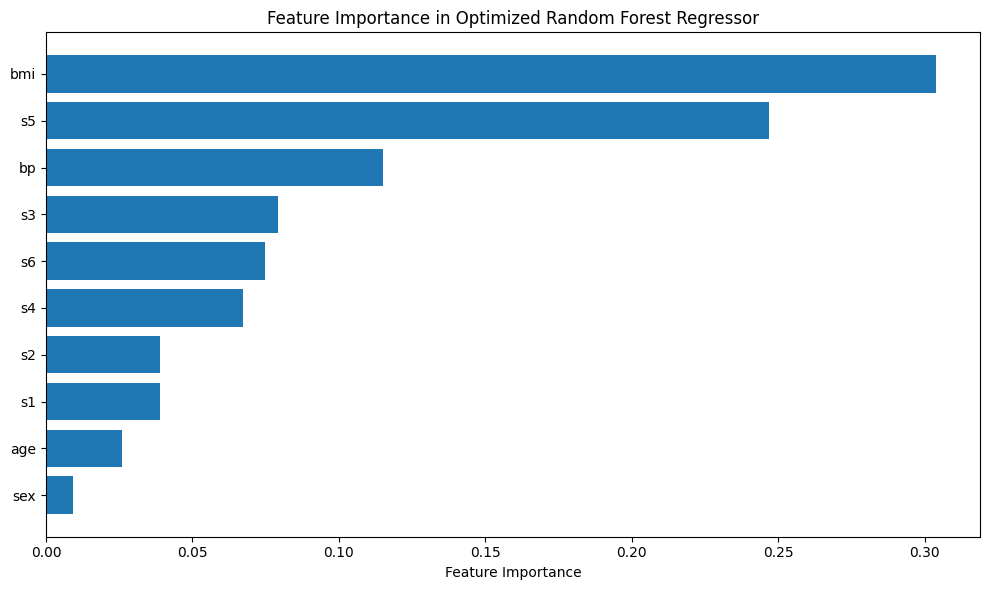

In [49]:
# Sort feature importances
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Optimized Random Forest Regressor')
plt.tight_layout()
plt.show()

# Part 5: Learning Curves for different hyperparameter settings

In [50]:
def plot_learning_curve(estimator, X, y, title, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [51]:
from sklearn.model_selection import learning_curve


In [52]:
# Plot learning curves for SVM with different hyperparameters
plt.figure(figsize=(15, 10))


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

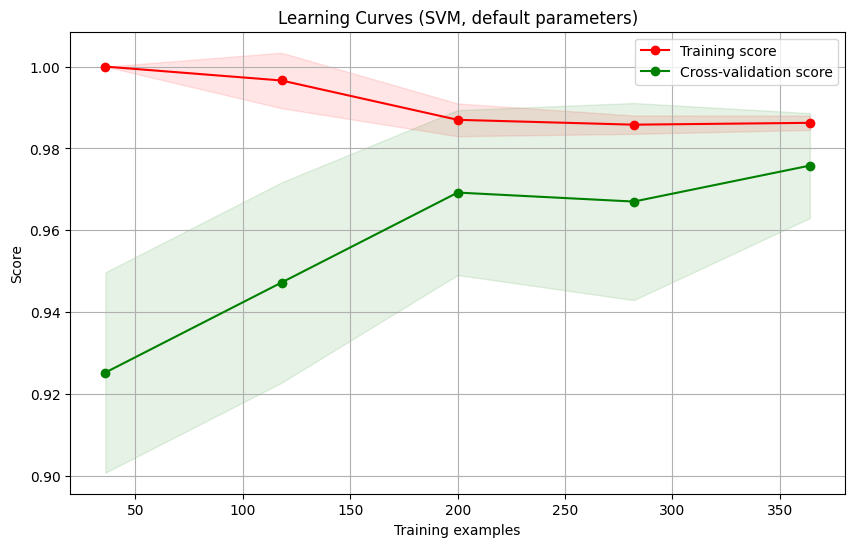

In [53]:
# Default parameters
svm_default = SVC(random_state=42)
plot_learning_curve(svm_default, X_class_train_scaled, y_class_train,
                   "Learning Curves (SVM, default parameters)")
plt.savefig('svm_default_learning_curve.png')

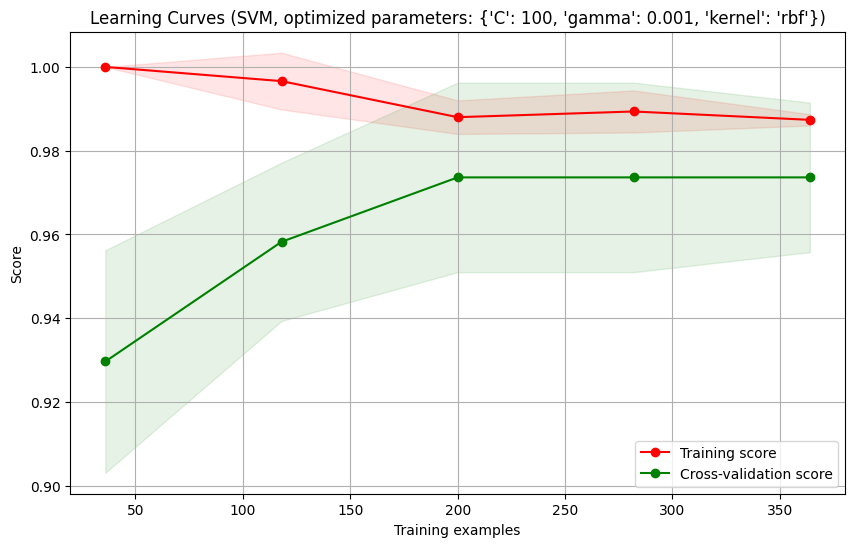

In [54]:
# Best parameters from grid search
svm_best = SVC(**grid_search.best_params_, random_state=42)
plot_learning_curve(svm_best, X_class_train_scaled, y_class_train,
                   f"Learning Curves (SVM, optimized parameters: {grid_search.best_params_})")
plt.savefig('svm_optimized_learning_curve.png')

# Part 6: Cross-validation visualization for different hyperparameters

In [55]:
# Function to run cross-validation with different hyperparameters and visualize results
def plot_cv_results(param_name, param_range, estimator, X, y, cv=5, scoring='accuracy'):
    cv_scores = []
    for param_value in param_range:
        params = {param_name: param_value}
        estimator.set_params(**params)
        scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
        cv_scores.append((param_value, np.mean(scores), np.std(scores)))

    cv_df = pd.DataFrame(cv_scores, columns=[param_name, 'Mean Score', 'Std Dev'])

    plt.figure(figsize=(10, 6))
    plt.errorbar(cv_df[param_name], cv_df['Mean Score'], yerr=cv_df['Std Dev'], marker='o')
    plt.title(f'Cross-validation scores for different {param_name} values')
    plt.xlabel(param_name)
    plt.ylabel('Mean CV Score')
    plt.grid(True)
    if param_name in ['C', 'gamma']:
        plt.xscale('log')
    return cv_df

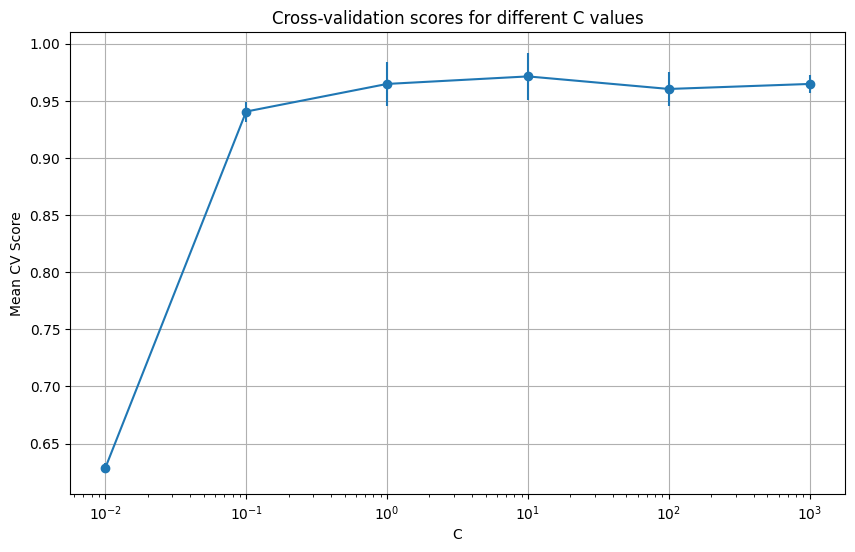

In [56]:
# Run CV visualization for C parameter
svm_model = SVC(kernel='rbf', gamma=0.01, random_state=42)
C_range = [0.01, 0.1, 1, 10, 100, 1000]
cv_results_C = plot_cv_results('C', C_range, svm_model, X_class_train_scaled, y_class_train)
plt.show()

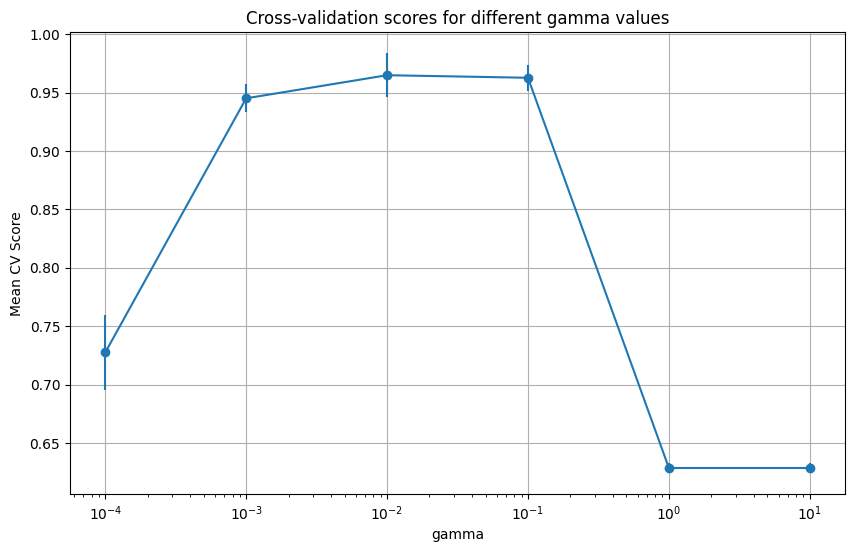

In [57]:
# Run CV visualization for gamma parameter
svm_model = SVC(kernel='rbf', C=1, random_state=42)
gamma_range = [0.0001, 0.001, 0.01, 0.1, 1, 10]
cv_results_gamma = plot_cv_results('gamma', gamma_range, svm_model, X_class_train_scaled, y_class_train)
plt.show()

# Part 7: Combining Grid Search and Random Search strategies

In [58]:
# Define a smaller search space for initial grid search
coarse_param_grid = {
    'C': [0.1, 10, 1000],
    'gamma': [0.001, 0.1, 10],
    'kernel': ['rbf', 'poly']
}

In [59]:
# Create GridSearchCV object for coarse search
coarse_grid_search = GridSearchCV(
    estimator=svm,
    param_grid=coarse_param_grid,
    cv=3,
    n_jobs=-1,
    verbose=0,
    scoring='accuracy'
)


In [60]:
# Perform coarse grid search
coarse_grid_search.fit(X_class_train_scaled, y_class_train)
best_C = coarse_grid_search.best_params_['C']
best_gamma = coarse_grid_search.best_params_['gamma']
best_kernel = coarse_grid_search.best_params_['kernel']

print(f"Coarse grid search best parameters: C={best_C}, gamma={best_gamma}, kernel={best_kernel}")


Coarse grid search best parameters: C=10, gamma=0.001, kernel=rbf


In [61]:
# Define refined search space around the best parameters
if best_kernel == 'rbf':
    refined_param_dist = {
        'C': uniform(best_C/3, best_C*3),
        'gamma': uniform(best_gamma/3, best_gamma*3),
        'kernel': ['rbf']
    }
else:
    refined_param_dist = {
        'C': uniform(best_C/3, best_C*3),
        'gamma': uniform(best_gamma/3, best_gamma*3),
        'kernel': ['poly'],
        'degree': [2, 3, 4, 5]
    }

In [62]:
# Create RandomizedSearchCV object for refined search
refined_random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=refined_param_dist,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=0,
    random_state=42,
    scoring='accuracy'
)

In [63]:
# Perform refined random search
refined_random_search.fit(X_class_train_scaled, y_class_train)

RandomizedSearchCV(cv=5, estimator=SVC(random_state=42), n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000217BCA73D10>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000217BA50D910>,
                                        'kernel': ['rbf']},
                   random_state=42, scoring='accuracy')

In [64]:
print(f"Refined random search best parameters: {refined_random_search.best_params_}")
print(f"Refined random search best score: {refined_random_search.best_score_:.4f}")

Refined random search best parameters: {'C': np.float64(21.55967889037648), 'gamma': np.float64(0.0008449057043952079), 'kernel': 'rbf'}
Refined random search best score: 0.9780


In [65]:
# Evaluate on test set
y_pred = refined_random_search.predict(X_class_test_scaled)
refined_accuracy = accuracy_score(y_class_test, y_pred)
print(f"Test accuracy with optimal parameters: {refined_accuracy:.4f}")


Test accuracy with optimal parameters: 0.9825


In [66]:
# Update comparison table
results_comparison['Method'] = pd.Categorical(
    results_comparison['Method'],
    categories=['Grid Search', 'Random Search', 'Bayesian Optimization', 'Combined Approach'],
    ordered=True
)


In [67]:
combined_approach = pd.DataFrame({
    'Method': ['Combined Approach'],
    'Best CV Score': [refined_random_search.best_score_],
    'Test Accuracy': [refined_accuracy],
    'Execution Time (s)': [None]  # We didn't time this approach
})

In [68]:
results_comparison = pd.concat([results_comparison, combined_approach], ignore_index=True)
print("\nComparison of all methods including combined approach:")
print(results_comparison)


Comparison of all methods including combined approach:
                  Method  Best CV Score  Test Accuracy  Execution Time (s)
0            Grid Search       0.973626       0.982456           71.383764
1          Random Search       0.971429       0.964912           18.599779
2  Bayesian Optimization       0.962637       0.956140           32.158671
3      Combined Approach       0.978022       0.982456                 NaN


C:\Users\Ali Computers\AppData\Local\Temp\ipykernel_15256\3157594516.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_comparison = pd.concat([results_comparison, combined_approach], ignore_index=True)


# Part 8: Visualizing hyperparameter importance

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [70]:
# Train a model with the best parameters from Bayesian search
best_svm = SVC(**bayes_search.best_params_, random_state=42, probability=True)
best_svm.fit(X_class_train_scaled, y_class_train)

SVC(C=47.479208101335, gamma=0.015041969444179404, probability=True,
    random_state=42)

In [71]:
# Create a dataset of different hyperparameter configurations and their performance
hyperparam_data = []
for i in range(len(grid_search.cv_results_['params'])):
    params = grid_search.cv_results_['params'][i]
    score = grid_search.cv_results_['mean_test_score'][i]

    # Encode the kernel
    kernel_rbf = 1 if params['kernel'] == 'rbf' else 0
    kernel_poly = 1 if params['kernel'] == 'poly' else 0

    hyperparam_data.append([params['C'], params['gamma'], kernel_rbf, kernel_poly, score])

hyperparam_df = pd.DataFrame(hyperparam_data,
                             columns=['C', 'gamma', 'kernel_rbf', 'kernel_poly', 'score'])

In [72]:
# Train a random forest to predict model performance based on hyperparameters
X_hyperparam = hyperparam_df.iloc[:, :-1].values
y_hyperparam = hyperparam_df.iloc[:, -1].values

rf_importance = RandomForestRegressor(n_estimators=100, random_state=42)
rf_importance.fit(X_hyperparam, y_hyperparam)

RandomForestRegressor(random_state=42)

In [73]:
# Get feature importances
importances = rf_importance.feature_importances_
feature_names = ['C', 'gamma', 'kernel_rbf', 'kernel_poly']

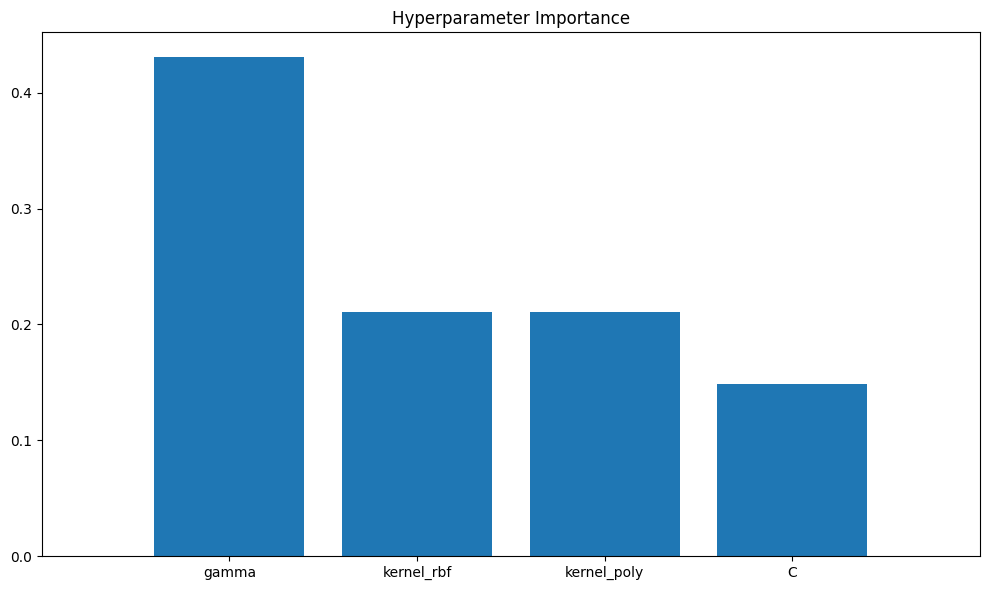

In [74]:
# Plot feature importances
plt.figure(figsize=(10, 6))
indices = np.argsort(importances)[::-1]
plt.title('Hyperparameter Importance')
plt.bar(range(X_hyperparam.shape[1]), importances[indices], align='center')
plt.xticks(range(X_hyperparam.shape[1]), [feature_names[i] for i in indices])
plt.xlim([-1, X_hyperparam.shape[1]])
plt.tight_layout()
plt.show()

In [75]:
# Calculate permutation importances as an alternative measure
perm_importance = permutation_importance(rf_importance, X_hyperparam, y_hyperparam,
                                         n_repeats=10, random_state=42)

C:\Users\Ali Computers\AppData\Local\Temp\ipykernel_15256\149670846.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False,


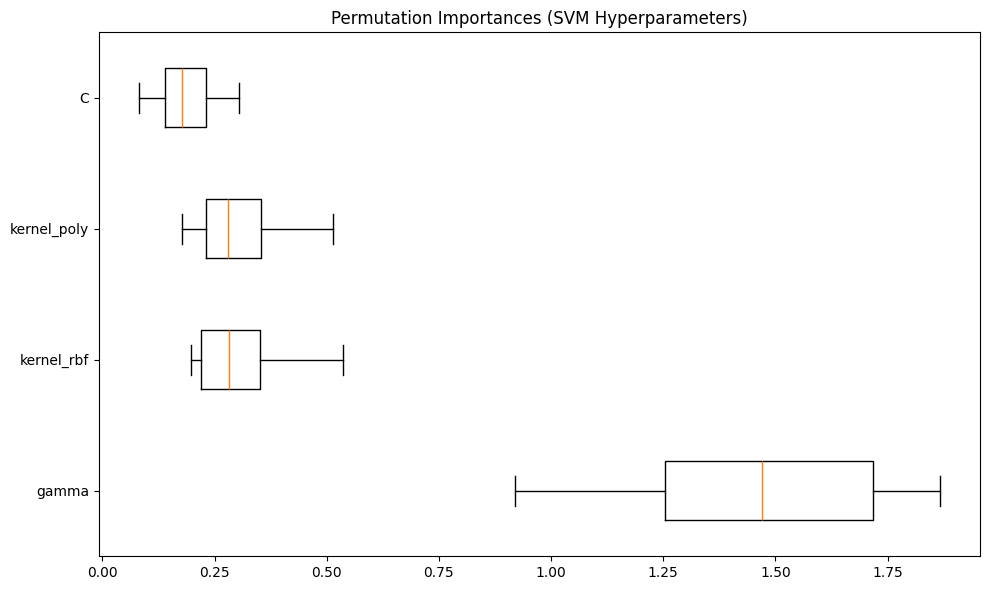

In [76]:
# Plot permutation importances
plt.figure(figsize=(10, 6))
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False,
            labels=[feature_names[i] for i in sorted_idx])
plt.title("Permutation Importances (SVM Hyperparameters)")
plt.tight_layout()
plt.show()

# Exercise

In [ ]:
# Student Exercise: Multi-Model Hyperparameter Optimization Challenge
# Time Estimate: 3-4 hours

# ==============================================================================
# INTRODUCTION
# ==============================================================================
# In this exercise, you'll implement and compare different hyperparameter tuning
# techniques across multiple models on a real-world dataset. You'll evaluate model
# performance, analyze the efficiency of various tuning methods, and build a meta-model
# to predict which algorithm performs best based on dataset characteristics.


In [77]:
# ==============================================================================
# PART 1: SETUP AND DATA PREPARATION
# ==============================================================================
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import time

# Load the California housing dataset
housing = fetch_california_housing()
X = housing.data  # Features (8 numerical features)
y = housing.target  # Target (median house value in $100,000s)
feature_names = housing.feature_names  # Feature names for reference

# TODO: Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42  # For reproducibility
)

# TODO: Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on train, transform train
X_test_scaled = scaler.transform(X_test)       # Transform test (no fit!)

Model           RMSE (mean)     RMSE (std)      R² (mean)       R² (std)       
Ridge           0.7205          0.0103          0.6115          0.0065         
SVR             0.5931          0.0106          0.7368          0.0048         
RandomForest    0.5114          0.0044          0.8042          0.0053         
GradientBoosting 0.5340          0.0071          0.7866          0.0032         


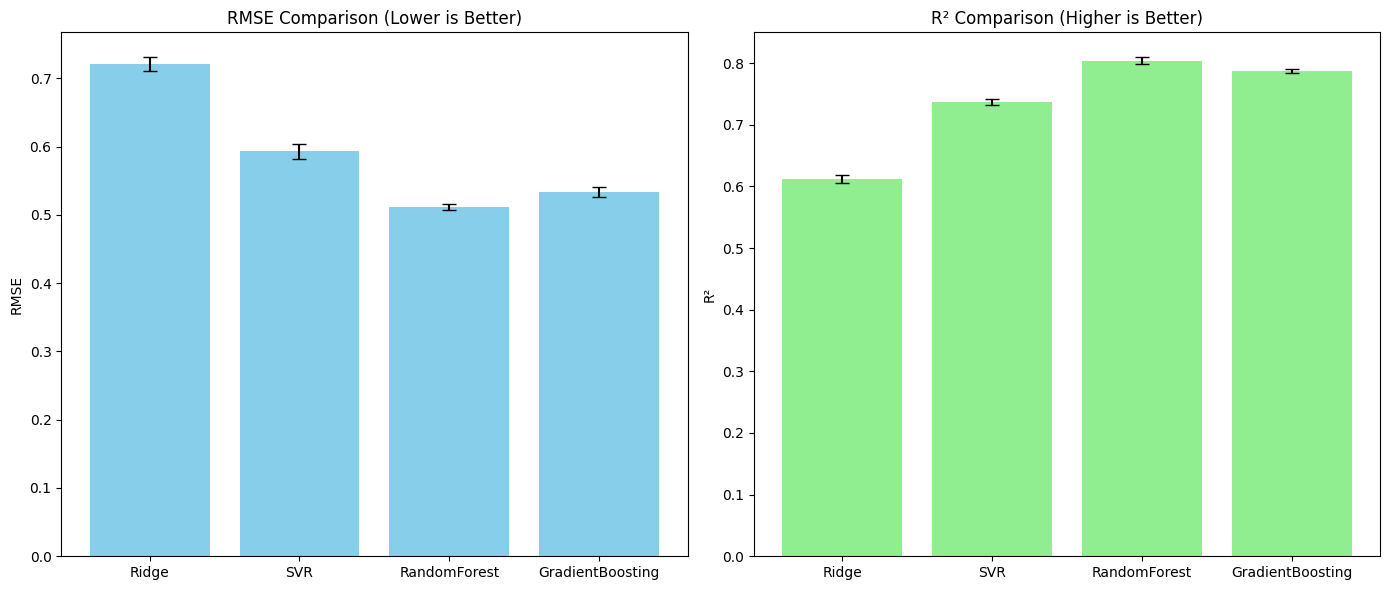

In [78]:
# ==============================================================================
# PART 2: BASELINE MODELS
# ==============================================================================
# Import models
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

# Create a dictionary of baseline models with default parameters
models = {
    'Ridge': Ridge(),
    'SVR': SVR(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

# Evaluate models using 5-fold cross-validation
metrics = {'RMSE': 'neg_root_mean_squared_error', 'R2': 'r2'}
results = {}

for name, model in models.items():
    cv_results = cross_validate(
        model, X_train_scaled, y_train,
        cv=5,
        scoring=metrics,
        return_train_score=False
    )
    results[name] = {
        'RMSE_mean': -cv_results['test_RMSE'].mean(),
        'RMSE_std': cv_results['test_RMSE'].std(),
        'R2_mean': cv_results['test_R2'].mean(),
        'R2_std': cv_results['test_R2'].std()
    }

# Print results
print(f"{'Model':<15} {'RMSE (mean)':<15} {'RMSE (std)':<15} {'R² (mean)':<15} {'R² (std)':<15}")
for name, res in results.items():
    print(f"{name:<15} {res['RMSE_mean']:<15.4f} {res['RMSE_std']:<15.4f} {res['R2_mean']:<15.4f} {res['R2_std']:<15.4f}")

# Visualize performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# RMSE plot
rmse_means = [res['RMSE_mean'] for res in results.values()]
rmse_stds = [res['RMSE_std'] for res in results.values()]
ax1.bar(results.keys(), rmse_means, yerr=rmse_stds, capsize=5, color='skyblue')
ax1.set_title('RMSE Comparison (Lower is Better)')
ax1.set_ylabel('RMSE')

# R² plot
r2_means = [res['R2_mean'] for res in results.values()]
r2_stds = [res['R2_std'] for res in results.values()]
ax2.bar(results.keys(), r2_means, yerr=r2_stds, capsize=5, color='lightgreen')
ax2.set_title('R² Comparison (Higher is Better)')
ax2.set_ylabel('R²')

plt.tight_layout()
plt.show()


Running Grid Search for Ridge
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Running Grid Search for SVR
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running Grid Search for RandomForest
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Running Grid Search for GradientBoosting
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Grid Search Results:
              Model  Best RMSE     Time (s)  \
3  GradientBoosting   0.468924   404.184955   
2      RandomForest   0.510322   618.725456   
1               SVR   0.568298  1073.092327   
0             Ridge   0.720527     4.929574   

                                         Best Params  
3  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...  
2  {'max_depth': 20, 'min_samples_split': 2, 'n_e...  
1       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}  
0                                    {'alpha': 0.01}  


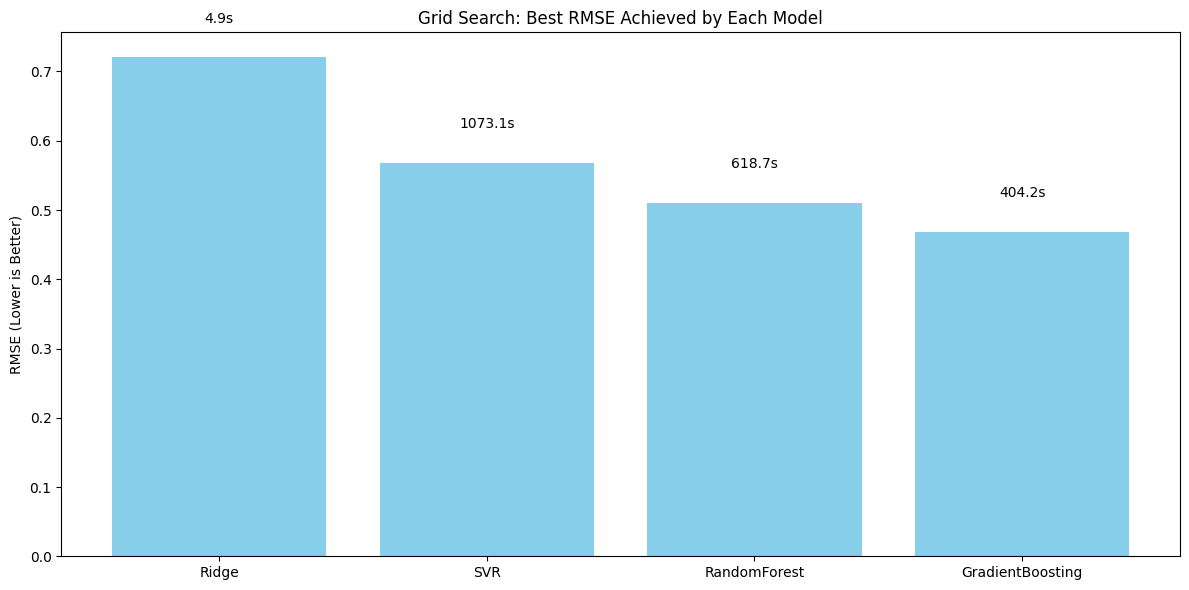

In [79]:
# ==============================================================================
# PART 3: HYPERPARAMETER TUNING USING GRID SEARCH
# ==============================================================================
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
param_grids = {
    'Ridge': {
        'alpha': [0.01, 0.1, 1, 10, 100]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.01, 0.1],
        'kernel': ['linear', 'rbf']
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

# Function to perform grid search
def run_grid_search(model, param_grid, X_train, y_train):
    start_time = time.time()
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    
    return {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,  # Convert back to positive RMSE
        'elapsed_time': elapsed_time
    }

# Apply grid search to all models
grid_results = {}
for model_name in models.keys():
    print(f"\n{'='*50}")
    print(f"Running Grid Search for {model_name}")
    print(f"{'='*50}")
    
    grid_results[model_name] = run_grid_search(
        models[model_name],
        param_grids[model_name],
        X_train_scaled,
        y_train
    )

# Display results
print("\nGrid Search Results:")
results_df = pd.DataFrame({
    'Model': grid_results.keys(),
    'Best RMSE': [res['best_score'] for res in grid_results.values()],
    'Time (s)': [res['elapsed_time'] for res in grid_results.values()],
    'Best Params': [res['best_params'] for res in grid_results.values()]
})
print(results_df.sort_values('Best RMSE'))

# Visualization
plt.figure(figsize=(12, 6))
plt.bar(results_df['Model'], results_df['Best RMSE'], color='skyblue')
plt.title('Grid Search: Best RMSE Achieved by Each Model')
plt.ylabel('RMSE (Lower is Better)')
for i, time_val in enumerate(results_df['Time (s)']):
    plt.text(i, results_df['Best RMSE'][i]+0.05, f"{time_val:.1f}s", ha='center')
plt.tight_layout()
plt.show()